tgb - 9/23/2019 - The goal of this notebook is to reproduce the target figures for Noah's interpretable ML paper

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import math
import matplotlib.pylab as pl
from pylab import *

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

# 1) Figure 2

tgb - 9/23/2019 - This figures bins all variables used for training as a function of two convection proxys:  
Lower-tropospheric stability:  
$$
\mathrm{LTS}=\theta\left(700\mathrm{hPa}\right)-\mathrm{SST}
$$  
Mid-tropospheric moisture:  
$$
Q_{m}=\int_{600\mathrm{hPa}}^{850\mathrm{hPa}}\frac{dp}{g}q_{v}
$$



## 1.1) Define models

### 1.1.1) Define PNAS models

In [3]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [4]:
scale_dict = load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/002_pnas_scaling.pkl')

In [5]:
input_transform = InputNormalizer(
    xr.open_dataset(f'/local/Tom.Beucler/SPCAM_PHYS/Noah32col_norm.nc'),
    in_vars,
    'mean', 'maxrs')

In [6]:
output_transform = DictNormalizer(xr.open_dataset(f'/local/Tom.Beucler/SPCAM_PHYS/Noah32col_norm.nc'), 
                                  out_vars, scale_dict)

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
def fc_model(input_shape, output_shape, hidden_layers, conservation_layer=False,
             inp_sub=None, inp_div=None, norm_q=None):
    inp = Input(shape=(input_shape,))

    # First hidden layer
    x = Dense(hidden_layers[0])(inp)
    x = LeakyReLU()(x)

    # Remaining hidden layers
    for h in hidden_layers[1:]:
        x = Dense(h)(x)
        x = LeakyReLU()(x)

    if conservation_layer:
        x = SurRadLayer(inp_sub, inp_div, norm_q)([inp, x])
        x = MassConsLayer(inp_sub, inp_div, norm_q)([inp, x])
        out = EntConsLayer(inp_sub, inp_div, norm_q)([inp, x])

    else:
        out = Dense(output_shape)(x)

    return tf.keras.models.Model(inp, out)

In [30]:
STABLENN_path = '/local/Tom.Beucler/SPCAM_PHYS/Noah8col_weights.h5'
UNSTABNN_path = '/local/Tom.Beucler/SPCAM_PHYS/Noah32col_weights.h5'

stabNN = fc_model(94, 65, [256]*9)
stabNN.load_weights(f'{STABLENN_path}')

unstabNN = fc_model(94, 65, [256]*9)
unstabNN.load_weights(f'{UNSTABNN_path}')

In [31]:
# Config and data files
config_a = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/006_8col_pnas_exact_Noah.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/007_32col_pnas_exact_Noah.yml']
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc']
data_ref = ['']
PNASarray = ['STAB','UNSTAB']

In [32]:
index = 0; # Choose dataset from data_fn_a [0 is +0K of length 5172]

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(PNASarray):
    print('NN name is ',NNs)
    if i==0: NN[NNs] = stabNN
    else: NN[NNs] = unstabNN;
    md[NNs] = ModelDiagnostics(NN[NNs],config_a[i],data_fn_a[index])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  STAB
NN name is  UNSTAB


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### 1.1.2) Define all other models

In [42]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc']
data_ref = ['']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNarray = ['JNNL','JNNC','MLRL0','JNNL0.01']

In [34]:
index = 0; # Choose dataset from data_fn_a [0 is +0K of length 5172]

NN = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[index])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  MLRL0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### 1.1.3) Concatenate both strings arrays to list all NN models

In [43]:
NNa = np.concatenate((PNASarray,NNarray)) # NNa contains all NN models

## 1.2) Constants

In [46]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [158]:
# User's choice
latTROP = [-22.5,22.5]
Nt = 500
iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))
pTBL = 850
pLTS = 700
pMT = 600
iTBL = nearest_index(coor.lev,pTBL).values
iLTS = nearest_index(coor.lev,pLTS).values
iMT = nearest_index(coor.lev,pMT).values

In [159]:
# Constants and conversion factor
kappa = 287.058/1004 # Poisson Constant to define potential temperature
p0 = 1015 # Pressure of sea surface (from Noah's paper)
LHF_CONV = 24*3600/L_V # Conversion of latent heat flux from W/m2 to mm/day
P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day
PNAS_PNORM = 2e-2 # Norm used to convert precipitation in mm/day for the PNAS network
theta_p = ((p0/coor.lev)**kappa).values # Vertical factor to calculate potential temperature
SST = coor.TS[0,:,0] # Sea surface temperature

## 1.3) Accumulate fields

In [160]:
NNname = 'JNNL' # Use any network to get inputs and truth

# Initialization
Qmid = np.zeros((len(iTROP[0]),len(coor.lon),1))
LTS = Qmid
QVtrop = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
Ttrop = QVtrop
PREC_NN = {}; HEAT_NN = {}; dTdt_NN = {}; dqdt_NN = {};
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),1))
    HEAT_NN[NNname] = PREC_NN[NNname]
    dTdt_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
    dqdt_NN[NNname] = dTdt_NN[NNname]
                               
PREC_NN['truth'] = PREC_NN[NNname]
HEAT_NN['truth'] = HEAT_NN[NNname]
dTdt_NN['truth'] = dTdt_NN[NNname]
dqdt_NN['truth'] = dqdt_NN[NNname]

In [161]:
for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md['JNNL'] # Reference model diagnostics object for microphysics NN
    m0 = md['STAB'] # Reference model diagnostics object for PNAS NN
    if itime==0: dP = m.dP(0)
    # Inputs and truth
    X, truth = m.valid_gen[itime]
    X0, truth0 = m0.valid_gen[itime]
    # Moisture profile
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)[iTROP,:,:]
    QVtrop = np.concatenate((QVtrop,np.expand_dims(QVgeo[0,:,:,:],axis=3)),axis=3)
    # Temperature profile
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    Tgeo = m.reshape_ngeo(T.values)[iTROP,:,:]
    Ttrop = np.concatenate((Ttrop,np.expand_dims(Tgeo[0,:,:,:],axis=3)),axis=3)
    # Mid-tropospheric moisture
    QMgeo = m.reshape_ngeo(np.expand_dims(np.sum(dP[:,iMT:(iTBL+0)]*QV[:,iMT:(iTBL+0)]/G,axis=1),axis=1))
    Qmid = np.concatenate((Qmid,QMgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # Lower-tropospheric stability
    TLTSgeo = m.reshape_ngeo(T.values*theta_p)[:,:,iLTS]-np.transpose(np.tile(SST,(len(coor.lon),1)))
    LTS = np.concatenate((LTS,np.moveaxis(TLTSgeo[iTROP,:],0,2)),axis=2)
    
    # Precipitation-Evaporation 
    # From microphysics NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        PRECIP_NN = P_CONV/(L_V*RHO_L)*np.sum(pred[:,-4:-2],axis=1)-\
        LHF_CONV*m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('LHFLX')][:,0].values
        PREC_NN[NNname] = np.concatenate((PREC_NN[NNname],m.reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:]),axis=2)
    # Truth
    PRECIP = P_CONV/(L_V*RHO_L)*np.sum(truth[:,-4:-2].values,axis=1)-\
    LHF_CONV*m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('LHFLX')][:,0].values
    PREC_NN['truth'] = np.concatenate((PREC_NN['truth'],m.reshape_ngeo(PRECIP)[iTROP,:,:][0,:,:,:]),axis=2)
    # From PNAS NN prediction
    for iNN,NNname in enumerate(PNASarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X0)
        PRECIP_NN = pred[:,-1]/PNAS_PNORM-\
        LHF_CONV*m.valid_gen.input_transform.inverse_transform(X0)[:,m.get_input_var_idx('LHFLX')][:,0].values
        PREC_NN[NNname] = np.concatenate((PREC_NN[NNname],m.reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:]),axis=2)
    
    # Net heating 
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        HEA_NN = m.reshape_ngeo(np.expand_dims(np.sum(pred[:,90:120],axis=1),axis=1))[iTROP,:,:][0,:,:,:]
        HEAT_NN[NNname] = np.concatenate((HEAT_NN[NNname],HEA_NN),axis=2)
    # Truth
    HEA_NN = m.reshape_ngeo(np.expand_dims(np.sum(truth[:,90:120].values,axis=1),axis=1))[iTROP,:,:][0,:,:,:]
    HEAT_NN['truth'] = np.concatenate((HEAT_NN['truth'],HEA_NN),axis=2)
    # From PNAS NN prediction
    for iNN,NNname in enumerate(PNASarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X0)[:,30:60]/output_transform.scale[30:60]
        HEA_NN = m.reshape_ngeo(np.expand_dims(np.sum(C_P*dP*pred/G,axis=1),axis=1))[iTROP,:,:][0,:,:,:]
        HEAT_NN[NNname] = np.concatenate((HEAT_NN[NNname],HEA_NN),axis=2)
    
    # Heating profile
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        dT_NN = m.reshape_ngeo(pred[:,90:120]*G/(C_P*dP))[iTROP,:,:]
        dTdt_NN[NNname] = np.concatenate((dTdt_NN[NNname],np.moveaxis(dT_NN,0,3)),axis=3)
    # Truth
    dT_NN = m.reshape_ngeo(truth[:,90:120].values*G/(C_P*dP))[iTROP,:,:]
    dTdt_NN['truth'] = np.concatenate((dTdt_NN['truth'],np.moveaxis(dT_NN,0,3)),axis=3)
    # From PNAS NN prediction
    for iNN,NNname in enumerate(PNASarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X0)[:,30:60]/output_transform.scale[30:60]
        dT_NN = m.reshape_ngeo(pred)[iTROP,:,:]
        dTdt_NN[NNname] = np.concatenate((dTdt_NN[NNname],np.moveaxis(dT_NN,0,3)),axis=3)
    
    # Moistening profile
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        dq_NN = m.reshape_ngeo(pred[:,:30]*G/(L_V*dP))[iTROP,:,:]
        dqdt_NN[NNname] = np.concatenate((dqdt_NN[NNname],np.moveaxis(dq_NN,0,3)),axis=3)
    # Truth
    dq_NN = m.reshape_ngeo(truth[:,:30].values*G/(L_V*dP))[iTROP,:,:]
    dqdt_NN['truth'] = np.concatenate((dqdt_NN['truth'],np.moveaxis(dq_NN,0,3)),axis=3)
    # From PNAS NN prediction
    for iNN,NNname in enumerate(PNASarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X0)[:,:30]/output_transform.scale[:30]
        dq_NN = m.reshape_ngeo(pred)[iTROP,:,:]
        dqdt_NN[NNname] = np.concatenate((dqdt_NN[NNname],np.moveaxis(dq_NN,0,3)),axis=3)

In [162]:
# Remove initial zero
QVtrop = QVtrop[:,:,:,1:]
Ttrop = Ttrop[:,:,:,1:]
Qmid = Qmid[:,:,1:]
LTS = LTS[:,:,1:]
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]
    HEAT_NN[NNname] = HEAT_NN[NNname][:,:,1:]
    dTdt_NN[NNname] = dTdt_NN[NNname][:,:,:,1:]
    dqdt_NN[NNname] = dqdt_NN[NNname][:,:,:,1:]
PREC_NN['truth'] = PREC_NN['truth'][:,:,1:]
HEAT_NN['truth'] = HEAT_NN['truth'][:,:,1:]
dTdt_NN['truth'] = dTdt_NN['truth'][:,:,:,1:]
dqdt_NN['truth'] = dqdt_NN['truth'][:,:,:,1:]

## 1.4) Take conditional expectation

In [163]:
# Histogram parameters
Nbin = 20
LTSmin = 7
LTSmax = 23
QMmin = 0
QMmax = 40

In [226]:
STR = np.concatenate((NNa,['truth'])) # String array containing all NNs + 'truth'
Whist = np.zeros((Nbin-1,Nbin-1))
PREChist = {}; HEAThist = {}; dTdthist = {}; dqdthist = {};
QVhist = np.zeros((Nbin-1,Nbin-1,len(coor.lev)))
Thist = QVhist
for iNN,NNname in enumerate(STR):
    PREChist[NNname] = np.zeros((Nbin-1,Nbin-1)) 
    HEAThist[NNname] = np.zeros((Nbin-1,Nbin-1))
    dTdthist[NNname] = np.zeros((Nbin-1,Nbin-1,len(coor.lev)))
    dqdthist[NNname] = np.zeros((Nbin-1,Nbin-1,len(coor.lev)))

LTSspace = np.linspace(LTSmin,LTSmax,num=Nbin)
QMspace = np.linspace(QMmin,QMmax,num=Nbin)

for binLTS,edgeLTS in enumerate(LTSspace):
    print('binLTS=',binLTS,'/',Nbin-1,' & edgeLTS=',edgeLTS,end="\r")
    if binLTS>0:
        for binQM,edgeQM in enumerate(QMspace):
            if binQM>0:
                w = (LTS>=edgeLTS_left)*(LTS<edgeLTS)*(Qmid>=edgeQM_left)*(Qmid<edgeQM)
                Whist[binQM-1,binLTS-1] = np.sum(w)
                if Whist[binQM-1,binLTS-1]==0:
                    QVhist[binQM-1,binLTS-1,:]=np.nan*QVhist[binQM-1,binLTS-1,:]
                    Thist[binQM-1,binLTS-1,:]=np.nan*Thist[binQM-1,binLTS-1,:]
                else:
                    QVhist[binQM-1,binLTS-1,:]=np.sum((np.moveaxis(np.tile(w,(30,1,1,1)),0,2)*QVtrop),
                                                      axis=(0,1,3))/np.sum(w)
                    Thist[binQM-1,binLTS-1,:]=np.sum((np.moveaxis(np.tile(w,(30,1,1,1)),0,2)*Ttrop),
                                                      axis=(0,1,3))/np.sum(w)
                for iNN,NNname in enumerate(STR):
                    if Whist[binQM-1,binLTS-1]==0: 
                        PREChist[NNname][binQM-1,binLTS-1]=np.nan
                        HEAThist[NNname][binQM-1,binLTS-1]=np.nan
                        dTdthist[NNname][binQM-1,binLTS-1,:]=np.nan*dTdthist[NNname][binQM-1,binLTS-1,:]
                        dqdthist[NNname][binQM-1,binLTS-1,:]=np.nan*dqdthist[NNname][binQM-1,binLTS-1,:]
                    else: 
                        PREChist[NNname][binQM-1,binLTS-1]=np.average(PREC_NN[NNname],weights=w)
                        HEAThist[NNname][binQM-1,binLTS-1]=np.average(HEAT_NN[NNname],weights=w)
                        dTdthist[NNname][binQM-1,binLTS-1,:]=np.sum((np.moveaxis(np.tile(w,(30,1,1,1)),0,2)*dTdt_NN[NNname]),
                                                                    axis=(0,1,3))/np.sum(w)
                        dqdthist[NNname][binQM-1,binLTS-1,:]=np.sum((np.moveaxis(np.tile(w,(30,1,1,1)),0,2)*dqdt_NN[NNname]),
                                                                    axis=(0,1,3))/np.sum(w)
            edgeQM_left = edgeQM
    edgeLTS_left = edgeLTS

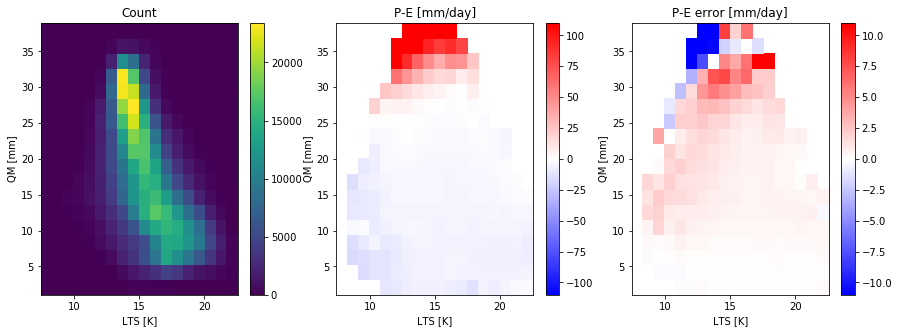

In [227]:
X = 0.5*(LTSspace[:-1]+LTSspace[1:])
Y = 0.5*(QMspace[:-1]+QMspace[1:])

NNname = 'UNSTAB'

#option_array = ['Weights','Precip','Hano','Heating']
option_array = ['Weights','Precip','Pano']

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i,option in enumerate(option_array):
    
    if option=='Weights': C = Whist; vlim=False; tit='Count'; cmaps = 'viridis'
    elif option=='Precip': C = PREChist[NNname]; vlim=True; vmin = -110; vmax = 110; cmaps = 'bwr'; tit='P-E [mm/day]'
    elif option=='Heating': C = HEAThist[NNname]; vlim=True; vmin = -3.5e3; vmax = 3.5e3; cmaps = 'bwr'; tit='Net heating [W/m2]'
    elif option=='Pano': C = PREChist[NNname]-PREChist['truth']; vlim=True; vmin = -11; vmax = 11; cmaps = 'bwr'; tit='P-E error [mm/day]'
    elif option=='Hano': C = HEAThist[NNname]-HEAThist['truth']; vlim=True; vmin = -70; vmax = 70; cmaps = 'bwr'; tit='Heating error [mm/day]'

    #ax0 = ax[math.floor(i/2),i%2]
    ax0 = ax[i]
    if vlim: im = ax0.pcolormesh(X, Y, C, vmin=vmin, vmax=vmax, cmap=cmaps)
    else: im = ax0.pcolormesh(X, Y, C, cmap=cmaps)

    plt.colorbar(im, ax=ax0)
    ax0.set_xlabel('LTS [K]')
    ax0.set_ylabel('QM [mm]')
    ax0.set_title(tit)
    
plt.savefig('/home/t/Tom.Beucler/Fig2'+NNname+'.pdf',format='pdf')

# 2) Figure 3

In [228]:
QMspace

array([ 0.        ,  2.10526316,  4.21052632,  6.31578947,  8.42105263,
       10.52631579, 12.63157895, 14.73684211, 16.84210526, 18.94736842,
       21.05263158, 23.15789474, 25.26315789, 27.36842105, 29.47368421,
       31.57894737, 33.68421053, 35.78947368, 37.89473684, 40.        ])

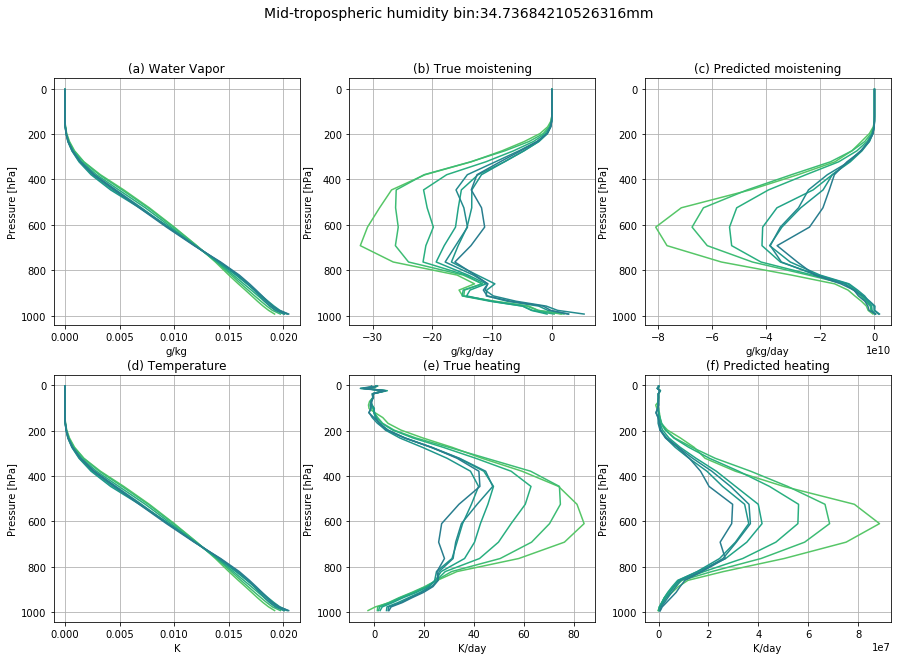

In [264]:
iQM = 16
NNname = 'UNSTAB'

fig, ax = plt.subplots(2,3,figsize=(15,10))

title_array = ['(a) Water Vapor','(b) True moistening','(c) Predicted moistening','(d) Temperature','(e) True heating','(f) Predicted heating']
xlab_array = ['g/kg','g/kg/day','g/kg/day','K','K/day','K/day']

n = 20
colors = pl.cm.viridis(np.linspace(0,1,n))
colors = colors[::-1,:] # Flip color palette to have moist in blue like Noah

for i,tit in enumerate(title_array):
    ax0 = ax[math.floor(i/3),i%3]
    
    if i==0: toplt = QVhist
    elif i==1: toplt = 1e3*24*3600*dqdthist['truth']
    elif i==2: toplt = 1e3*24*3600*dqdthist[NNname]
    elif i==3: toplt = QVhist # Replace with Thist ASAP
    elif i==4: toplt = 24*3600*dTdthist['truth']
    elif i==5: toplt = 24*3600*dTdthist[NNname]
    elif i==6: toplt = qhist
    
    for iLTS,edgeLTS in enumerate(LTSspace):
        if iLTS*Whist[iQM,iLTS-1]>0:
            ax0.plot(toplt[iQM,iLTS-1,:],coor.lev,color=colors[iLTS-1])
    
    ax0.set_xlabel(xlab_array[i])
    ax0.set_ylabel('Pressure [hPa]')
    ax0.set_title(tit)
    ax0.invert_yaxis()
    ax0.grid()

gcf().suptitle("Mid-tropospheric humidity bin:"+str(0.5*(QMspace[iQM]+QMspace[iQM+1]))+"mm", fontsize=14)
plt.savefig('/home/t/Tom.Beucler/Fig3'+NNname+'.pdf',format='pdf')

# 3) Figure 4

In [257]:
LTSspace

array([ 7.        ,  7.84210526,  8.68421053,  9.52631579, 10.36842105,
       11.21052632, 12.05263158, 12.89473684, 13.73684211, 14.57894737,
       15.42105263, 16.26315789, 17.10526316, 17.94736842, 18.78947368,
       19.63157895, 20.47368421, 21.31578947, 22.15789474, 23.        ])

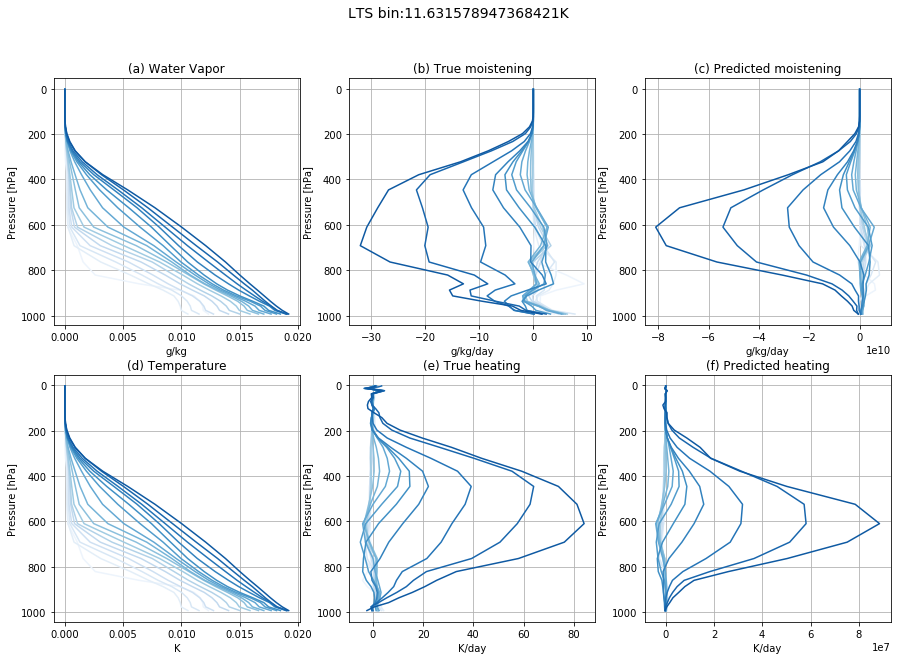

In [267]:
iLTS = 5
NNname = 'UNSTAB'

fig, ax = plt.subplots(2,3,figsize=(15,10))

title_array = ['(a) Water Vapor','(b) True moistening','(c) Predicted moistening','(d) Temperature','(e) True heating','(f) Predicted heating']
xlab_array = ['g/kg','g/kg/day','g/kg/day','K','K/day','K/day']

n = 20
colors = pl.cm.Blues(np.linspace(0,1,n))

for i,tit in enumerate(title_array):
    ax0 = ax[math.floor(i/3),i%3]
    
    if i==0: toplt = QVhist
    elif i==1: toplt = 1e3*24*3600*dqdthist['truth']
    elif i==2: toplt = 1e3*24*3600*dqdthist[NNname]
    elif i==3: toplt = QVhist # Replace with Thist ASAP
    elif i==4: toplt = 24*3600*dTdthist['truth']
    elif i==5: toplt = 24*3600*dTdthist[NNname]
    elif i==6: toplt = qhist
    
    for iQM,edgeQM in enumerate(LTSspace):
        if iLTS*Whist[iLTS,iQM-1]>0:
            ax0.plot(toplt[iQM-1,iLTS,:],coor.lev,color=colors[iQM-1])
    
    ax0.set_xlabel(xlab_array[i])
    ax0.set_ylabel('Pressure [hPa]')
    ax0.set_title(tit)
    ax0.invert_yaxis()
    ax0.grid()

gcf().suptitle("LTS bin:"+str(0.5*(LTSspace[iLTS]+LTSspace[iLTS+1]))+"K", fontsize=14)
plt.savefig('/home/t/Tom.Beucler/Fig4'+NNname+'.pdf',format='pdf')